#Modelling and exploring Leone Allacci's _Drammaturgia_




## 1. Modellation

In [ ]:
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import csv
import json

### Information retrieval

#### Title and subtitle

In [ ]:
def extract_title(sentence):
    # Find the first element in the sentence up to the full stop
    match = re.search(r'[^.]*\.', sentence)

    if match:
        # Extract the matched text
        matched_text = match.group().strip(".")

        # Check for the presence of "ovvero" or "o sia"
        if "ovvero" in matched_text or "o sia" in matched_text:
            # Split the text into title and subtitle
            title, _, subtitle = re.split(r'\s*(ovvero|o sia|o siano)\s*', matched_text, maxsplit=1)
            title = title.strip()
            subtitle = subtitle.strip()
            if title.endswith:
              title = title.strip(",")
            if subtitle.startswith(", "):
              subtitle = subtitle[2:]
            return title.title(), subtitle.title()
        else:
            # If "ovvero" or "o sia" is not present, set subtitle_one to None
            title = matched_text.strip()
            return title.title(), None
    else:
        return None, None

#### Genre

In [ ]:
def extract_genre(sentence):
    # Find the first full stop in the sentence
    first_full_stop_match = re.search(r'(?<!\b[SIVX])\.', sentence)

    if first_full_stop_match:
        # Find the second full stop or a parenthesis in the remaining text
        second_full_stop_match = re.search(r'\.|\(', sentence[first_full_stop_match.end():])

        if second_full_stop_match:
            # Extract text from the first full stop to the second full stop
            text_after_full_stop = sentence[first_full_stop_match.end():first_full_stop_match.end() + second_full_stop_match.end()]
            genre = text_after_full_stop.strip().strip(".|(")

            # Keep only the first two words of the genre
            genre_words = genre.split()
            genre = ' '.join(genre_words[:2])

            genre = genre.replace(" di","")
            genre = genre.replace(" per","")
            genre = re.sub(r' recitata| recitato| rappresentata| rappresentato| dedicato', '', genre)
            genre = genre.strip()

            if genre == 'Op':
                genre = 'Opera'
            if genre.startswith('Rappresentata'):
                genre = '?'
            elif genre.startswith('in') or genre.startswith('— in'):
                genre = '?'
            return genre
    else:
        return None

#### Mode

In [ ]:
def extract_mode(entry):
    mode = None

    if 'prosa' in entry.lower():
        mode = 'prose'
    elif 'versi' in entry.lower() or 'ottava rima' in entry.lower():
        mode = 'verse'

    return mode

#### City

In [ ]:
def extract_city(entry):

    # check for "Senza luogo" outside the loop
    if "senza luogo" in entry:
        return "?"

    # let's temporarily remove expressions which confuse the parser

    strings = ["in prosa", "in versi", "in due", "in quattro",
               "in ottava", "in terza", "in terzine", "in forma",
               "in luce", "in atto", "in cinque", "in musica",
               "in Musica", "in occasione", "in verso", "in lingua",
               "in Lingua", "in tre", "in Amore", "in data", "in una",
               "in Italiano", "in terzetti", "in Atti", "in S.",
               "in Casa", "in applauso", "in un", "in cui", "in onore",
               "recitato in", "rappresentato in"]  # we remove also what points to staging location
    for string in strings:
      if string in entry:
        entry = entry.replace(string, "")

    # remove uppercase words
    entry = re.sub(r'IN [A-Z]+', '', entry)

    city_pattern = re.compile(r'(?i)in\s([^\s\d]+)')
    match = city_pattern.search(entry)

    city = match.group(1) if match else None
    if city:
      city = city.strip(",")
      city = city.strip(".")
      if city in ["Ven", "Venez","Vinegia"]:
        city = "Venezia"
      if "." in city:
        city = city.replace(".", "")
    return city


#### Location

In [ ]:
def extract_location(entry):
    # Define the pattern for capturing location after "Teatro di"
    location_pattern = re.compile(r'Teatro\s+([^\s]+)\s([^\s]+)\s([^\s]+)\s([^\s]+)\s([^\s]+)')

    # Search for the pattern in the input string
    match = location_pattern.search(entry)

    # If the pattern is found, return the matched location as a string
    if match:
        location = ' '.join(match.groups())  # Join the captured groups into a single string
        #print(location)
        location = re.sub(r"l'anno\s+\d{4}", "", location)
        location = re.sub(r"l'anno", "", location)
        location = re.sub(r"Poesia", "", location)
        location = re.sub(r"", "", location)
        if location.startswith(("de", "di")):
          location = location[3:]
        if location.endswith("di"):
          location = location[:-3]
        elif location.startswith(("Ebraico", "Comico", "Tragico", "pubblicato")):
          location = None

        return location
    else:
        return None


####Publisher

In [ ]:
def extract_publisher(entry):

    # Let's temporarily remove misdirections from the entry
    strings = ["per Musica","per comando", "di Personaggi", "per le "]
    for string in strings:
      if string in entry:
        entry = entry.replace(string, "")

    # Check for "Senza Stampatore" outside the loop
    if "senza Stampatore" in entry or "senza nome di Stampatore" in entry :
        return "?"
    if "e Stampatore" in entry or ", Stampatore" in entry :
        return "?"

    # Define sets of publisher expressions within the function
    pointer_sets = [
        ("per il ", "per gli ", "presso il ", "presso gli ", "nella Stamperia del "),
        ("per ", "pel ", "presso ", "appr\. ", "nella Stamperia ", "nella Stampa "),
        ("appresso ","ad istanza del ", "ad istanza di ", "all'Insegna ")
    ]

    # Iterate through each set of pointers
    for pub_pointers in pointer_sets:
        # Combine the current set of pointers into a regex pattern
        pub_pattern_str = '|'.join(pub_pointers)
        publisher_pattern = re.compile(fr'(?i)\b(?:{pub_pattern_str})\s*([^.,]+)[.,]')

        # Use the regex pattern to search for a match in the input string
        match = publisher_pattern.search(entry)

        # If a match is found, extract and return the publisher information
        if match:
            if "Gio." in match.group(0):
                # Take the following two words as the publisher
                publisher_words = re.findall(r'\b\w+\b', entry)
                publisher_index = publisher_words.index("Gio") + 1
                return ' '.join(publisher_words[publisher_index: publisher_index + 2])
            else:
                # Extract and return the publisher information
                publisher = match.group(1).strip()
                if publisher.startswith("l'"):
                    publisher = publisher[2:]  # Remove "l'"
                if publisher == "Pietro Van":
                  publisher = "Pietro Van Ghelen"
                if publisher == "Niccolini":
                  publisher = "Francesco Niccolini"
                if "Ducale" in publisher:
                  publisher = "Stamperia Ducale"
                if "Imperiale" in publisher:
                  publisher = "Stamperia Imperiale"
                if "della Rev" in publisher:
                  publisher = "Stamperia della Camera Apostolica"
                return publisher

    # If no match is found in any set of pointers, return None
    return None

####Year

In [ ]:
def extract_year(entry):

    # check for "Senza anno" outside the loop
    if "senz'anno" in entry.lower() or "senza anno" in entry.lower() or "re, ed anno" in entry.lower():
        return "Unknown"

    # Define the pattern for finding the year followed by "in"
    year_pattern = re.compile(r'(\d{4})\s*in', re.IGNORECASE)

    # Search for the pattern in the input string
    match = year_pattern.search(entry)

    # If the pattern is found, return the matched year
    if match:
        year = int(match.group(1))
        return year
    else:
        # If the pattern is not found, try finding any year pattern
        general_year_pattern = re.compile(r'(\d{4})')
        general_match = general_year_pattern.search(entry)
        general_year = int(general_match.group(1)) if general_match else None
        return general_year

####Format

In [ ]:
def extract_format(entry):
    format_pattern = re.compile(r'in\s(\d+)')
    match = format_pattern.search(entry)
    format = match.group(1) if match else None
    return format

####Author

In [ ]:
def extract_author(entry):

    # Check for "incerto" outside the loop
    if "incerto" in entry.lower():
        return "?"

    # titles and honorifics to be removed
    titles = ["Co. ","Conte ","Ab. ","Abate ", "P. ", "Padre", "Fr. ", "Monsign. ",
              "Don ", "Dott. ", "Dottore ", "Dottor ", "D. ", "Fra ", "F. ", "Marchese "]

    # Define the pattern for capturing two words after dash and "di" or "Poesia di"
    author_pattern = re.compile(r'(?:— di|— da|— del[l\']|— del|— dal|Poesia di|Poesia del)\s*([^,]+ [^,]+)')

    # Search for the pattern in the input string
    match = author_pattern.search(entry)

    # If the pattern is found, return the matched author
    if match:
        author = match.group(1).strip()
        # remove titles
        for title in titles:
          if title in author:
            author = author.replace(title, "")
        # fix residual issues
        author = re.sub(r'\. — .*$', '', author)
        author = author.strip(".,")
        if author.startswith("l'"):
            author = author.replace("l'", "")
        if author.startswith("l "):
            author = author[2:]
        if author.startswith("'"):
            author = author.replace("'", "")
        if author.endswith("."):
          author = author.replace(".", "")
        if author.startswith("Polisseno Fegejo Pastor Arcade"):
                author = "Carlo Goldoni"
        return author
    else:
        return None

####Libretto

In [ ]:
def check_if_libretto(entry):
    libretto = None

    if 'musica di' in entry.lower() or 'per musica' in entry.lower():
        libretto = True
    else:
        libretto = False

    return libretto

#### Composer

In [ ]:
def extract_composer(entry):

    # Check for "incerto" outside the loop
    if "musica d'incerto" in entry.lower():
        return "?"
    if "musica di diversi" in entry.lower():
        return "?"

    # titles and honorifics to be removed
    titles = ["Co. ","Conte ","Ab. ","Abate ", "P. ", "Padre", "Fr. ", "Monsign. ",
              "Don ", "Dott. ", "Dottore ", "Dottor ", "D. ", "Fra ", "F. ", "Marchese "]

    # Define the pattern for capturing composer
    composer_pattern = re.compile(r'(?:Musica di|Musica del)\s*([^,]+ [^,]+)')

    # Search for the pattern in the input string
    match = composer_pattern.search(entry)

    # If the pattern is found, return the matched composer
    if match:
        try:
          composer = match.group(1).strip()
          # remove titles
          for title in titles:
            if title in composer:
              composer = composer.replace(title, "")
          # fix residual issues
          composer = re.sub(r'\. — .*$', '', composer)
          composer = re.sub(r'Cav\.', '', composer)
          composer = composer.strip(".,")
          if composer.startswith("l'"):
              composer = composer.replace("l'", "")
          if composer.startswith(" "):
              composer = composer.replace(" ", "")
          if composer.startswith("l "):
              composer = composer[2:]
          if composer.startswith("'"):
              composer = composer.replace("'", "")
          if composer.endswith("."):
            composer = composer.replace(".", "")
          return composer
        except:
          return None
    else:
        return None

####Translation

In [ ]:
def check_if_translation(entry):
    translation = None

    if 'tradot' in entry.lower() or "traduz" in entry.lower():
        translation = True
    else:
        translation = False

    return translation

###Database building

In [ ]:
url = 'https://raw.githubusercontent.com/allacci-digitale/allacci-digitale.github.io/main/data/cleaned-transcription.txt'
response = requests.get(url).text
entries = response.split('\n')

# Create a DataFrame
df = pd.DataFrame({"voce/entry": entries})

In [ ]:
# extract info and fill the df

df['titolo/title'], df['sottitolo/subtitle'] = zip(*df['voce/entry'].apply(extract_title))
df['autore/author'] = df['voce/entry'].apply(extract_author)
df['genere/genre'] = df['voce/entry'].apply(extract_genre)
df['metro/mode'] = df['voce/entry'].apply(extract_mode)
df['luogo di pubblicazione/city'] = df['voce/entry'].apply(extract_city)
df['luogo di rappresentazione/location'] = df['voce/entry'].apply(extract_location)
df['editore/publisher'] = df['voce/entry'].apply(extract_publisher)

df['anno/year'] = df['voce/entry'].apply(extract_year)
df['anno/year'] = pd.to_numeric(df['anno/year'], errors='coerce')
df['anno/year'] = df['anno/year'].fillna(0).astype(int)

df['formato/format'] = df['voce/entry'].apply(extract_format)
df['libretto'] = df['voce/entry'].apply(check_if_libretto)
df['compositore/composer'] = df['voce/entry'].apply(extract_composer)
df['traduzione/translation'] = df['voce/entry'].apply(check_if_translation)

# Display the resulting DataFrame
df.head(5)

,voce/entry,titolo/title,sottitolo/subtitle,autore/author,genere/genre,metro/mode,luogo di pubblicazione/city,luogo di rappresentazione/location,editore/publisher,anno/year,formato/format,libretto,compositore/composer,traduzione/translation
0,ABBAGLI FELICI. Commedia (in prosa). — In Mace...,Abbagli Felici,None,Prospero Bonarelli della Rovere,Commedia,prose,Macerata,None,Agostino Grisei,1642,12,False,None,False
1,ABBANDONO D'ARMIDA. Trattenimento scenico cant...,Abbandono D'Armida,None,Giovanni Boldini,Trattenimento scenico,verse,Venezia,Grimani di San Gian—Grisostomo,Carlo Buonarrigo,1729,12,True,?,False
2,ABBATE. Commedia (in prosa). — in Venez. appre...,Abbate,None,Bartolommeo Cappello,Commedia,prose,Venezia,None,Agostino Bindoni,1556,8,False,None,False
3,ABBISAI. Op. (in prosa). — in Milano per il Ma...,Abbisai,None,Carlo Giuseppe Cornacchia,Opera,prose,Milano,None,Malatesta,1718,12,False,None,False
4,ABDOLOMINO. Dramma rappresentato alle Sac. Ces...,Abdolomino,None,Silvio Stampiglia,Dramma,None,Vienna,None,gli Eredi Cosmeroviani,1709,8,True,Giovanni Bononcini,False


#### Debug

In [ ]:
#print(df[df['anno/year'] == 0])

In [ ]:
# debug nones

none_entries = df.loc[df['autore/author'].isnull(), "voce/entry"]

for entry in none_entries:
    print(entry)

In [ ]:
# debug strange stuff
unique_values = df['luogo di rappresentazione/location'].value_counts()
sorted_values = unique_values.sort_values(ascending=False)
for value, frequency in sorted_values.items():
  #if type(value) == int and value < 1500:
  print(f"{value} {frequency}")

Sant'Angiolo di Venezia  123
S. Gio. Grisostomo 64
 SS. Gio. e Paolo 49
S. Cassiano di Venezia 41
S. Mosè di Venezia 34
S. Salvatore di Venezia 34
San Cassiano di Venezia 32
San Mosè di Venezia 23
San Salvatore di Venezia 19
SS. Gio. e Paolo 17
San Fantino di Venezia 12
S. Fantino di Venezia 12
Sant'Apollinare di Venezia  12
San Gio. Grisostomo 12
San Samuele di Venezia 10
San Mosè  10
S. Cassiano  9
Formagliari di Bologna. —  8
S. Samuele di Venezia 7
Formagliari di Bologna  7
S. Mosè  6
S. Cassiano di Venezia. 6
 S. S. Gio. e 6
San Cassiano  5
S. Salvatore. — in 5
S. Mose di Venezia 5
S. S. Gio. e 5
Sant'Angiolo  in 4
San Gio. Grisostomo  4
Sant'Angiolo di Venezia. — 4
S. Mosè. — in 4
S. Gio. Grisostomo. — 4
S. Gio. Grisostomo  4
Obizzi di Padova  4
S. Angiolo di Venezia 4
Marsigli Rossi di Bologna. — 4
San Cassiano. — in 3
San Samuelle di Venezia 3
 SS. Gio. e Paolo. 3
S. Angelo di Venezia 3
le Grazie di Vicenza  3
S. Cassiano. — in 3
 Sig. Co. Pinamonte Bonacossi. 3
San Cassiano di

In [ ]:
# find recurrent empty fields

for column in df.columns:
    none_count = df[column].apply(lambda x: x is None).sum()
    total_entries = len(df[column])
    percent_none = ((none_count / total_entries) * 100 if total_entries > 0 else 0).round(2)
    print(f"In the '{column}' column there are {none_count} None values out of {total_entries} ---> {percent_none}")

#### Export database

In [ ]:
df.head()

In [ ]:
df.to_csv("database.csv")
#df.to_json("database.json") # this fails

csv_file = 'database.csv'
json_file = 'database.json'

with open(csv_file, 'r') as f:
    csv_data = [dict(row) for row in csv.DictReader(f)]

with open(json_file, 'w') as f:
    json.dump(csv_data, f, indent=4)


##2. Exploratory data analysis

In [ ]:
count_entries = ((df['year'] >= 1561) & (df['year'] <= 1710)).sum()
print("Number of texts between 1561 and 1710:", count_entries)

Number of texts between 1561 and 1710: 3816


In [ ]:
def visualise(info, plot_type):
    filtered_df = df[df[info].notna() & (df[info] != "Unknown")]

    # Get the top 15 entries sorted by frequency
    top_15_values = filtered_df[info].value_counts().head(15)

    # Print the top 15 values and their frequencies
    for value, frequency in top_15_values.items():
        print(f"{value}: {frequency}")

    # Create a DataFrame for the top 15 values
    top_15_df = filtered_df[filtered_df[info].isin(top_15_values.index)]

    # Sort values by frequency in descending order
    sorted_values = top_15_df[info].value_counts().index

    # Dynamically call the specified plot method
    getattr(plt, plot_type)(sorted_values, top_15_df[info].value_counts(),
                            color='darkred', edgecolor='black')

    plt.xlabel(f"{info}")
    plt.ylabel('frequency')

    # Set x-axis ticks and labels based on sorted order of frequencies
    plt.xticks(sorted_values, [f'{value}' for value in sorted_values], rotation=90, ha="right")

    plt.show()

Apostolo Zeno: 125
Niccolò Minato: 73
Francesco Silvani: 72
Carlo Goldoni: 72
Pietro Metastasio: 55
Giacinto Andrea Cicognini: 47
Matteo Noris: 41
Ortensio Scamacca: 38
Pier Jacopo Martello: 33
Aurelio Aurelj: 31
Antonio Salvi: 30
Girolamo Gigli: 26
Arcangelo Spagna: 25
Domenico Lalli: 21
Girolamo Bartolommei: 20


ConversionError: Failed to convert value(s) to axis units: Index(['Apostolo Zeno', 'Niccolò Minato', 'Francesco Silvani', 'Carlo Goldoni',
       'Pietro Metastasio', 'Giacinto Andrea Cicognini', 'Matteo Noris',
       'Ortensio Scamacca', 'Pier Jacopo Martello', 'Aurelio Aurelj',
       'Antonio Salvi', 'Girolamo Gigli', 'Arcangelo Spagna', 'Domenico Lalli',
       'Girolamo Bartolommei'],
      dtype='object', name='author')

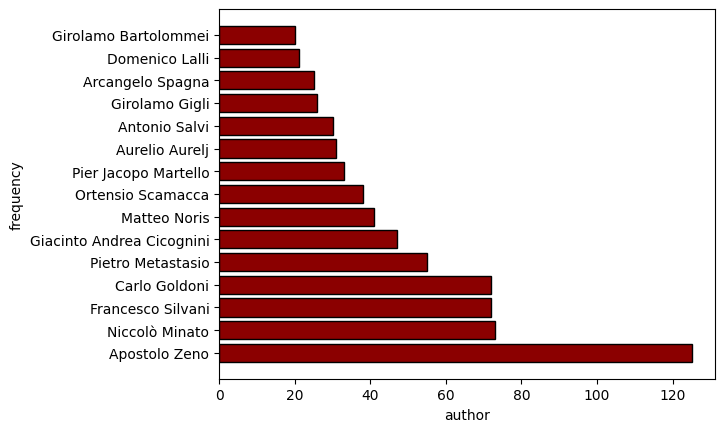

In [ ]:
visualise('author',plot_type="barh")

In [ ]:
# plot locations

data = {'Venezia': 1814, 'Bologna': 517, 'Roma': 359, 'Napoli': 358, 'Firenze': 351,
        'Vienna': 241, 'Palermo': 208, 'Siena': 195, 'Milano': 159, 'Ferrara': 91,
        'Viterbo': 90, 'Padova': 87, 'Verona': 74, 'Mantova': 56, 'Vicenza': 55,
        'Macerata': 52, 'Parma': 49, 'Modena': 46, 'Ronciglione': 40, 'Genova': 38,
        'Lucca': 34, 'Perugia': 32, 'Brescia': 31, 'Torino': 30, 'Lipsia': 30}

# Simplified dataset of city coordinates (latitude, longitude)
city_coordinates = {
      'Venezia': (45.4408474, 12.3155151),
      'Bologna': (44.494887, 11.342616),
      'Roma': (41.9027835, 12.4963655),
      'Napoli': (40.852162, 14.2681103),
      'Firenze': (43.7695604, 11.2558136),
      'Vienna': (48.2083537, 16.3725042),
      'Palermo': (38.1157, 13.3615),
      'Siena': (43.3186, 11.3307),
      'Milano': (45.4642, 9.1900),
      'Ferrara': (44.8350, 11.6180),
      'Viterbo': (42.4174, 12.1047),
      'Padova': (45.4064, 11.8768),
      'Verona': (45.4384, 10.9916),
      'Mantova': (45.1569, 10.7910),
      'Vicenza': (45.5455, 11.5350),
      'Macerata': (43.3000, 13.4532),
      'Parma': (44.8015, 10.3279),
      'Modena': (44.6471, 10.9252),
      'Ronciglione': (42.2711, 12.1987),
      'Genova': (44.4056, 8.9463),
      'Lucca': (43.8420, 10.5027),
      'Perugia': (43.1107, 12.3890),
      'Brescia': (45.5416, 10.2118),
      'Torino': (45.0703, 7.6869),
      'Lipsia': (51.3432, 12.3809)
}

# Create a map centered around Italy
m = folium.Map(location=[41.8719, 12.5674], zoom_start=4)

# Add markers for each city with the size proportional to the number of events
for city, events in data.items():
    coordinates = city_coordinates.get(city)
    if coordinates:
        folium.CircleMarker(
            location=coordinates,
            radius=events / 50,  # Adjust the scaling factor as needed
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.2,
            popup=f"{city}: {events} events"
        ).add_to(m)

# Display the map in Colab
m

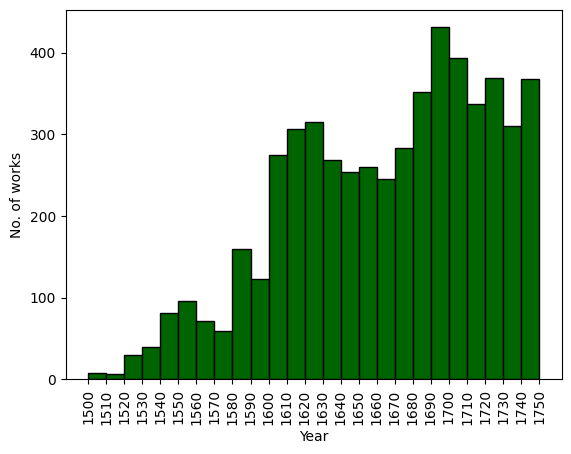

In [ ]:
# print the corpus' diachronic span

filtered_df = df[df['year'].notna() & (df['year'] != "Unknown")]

# Plot histogram
plt.hist(filtered_df['year'], bins=range(1500, 1760, 10), color="darkgreen", edgecolor='black')

# Set major labels every 50 years
major_labels = range(1500, 1760, 10)
plt.xticks(major_labels, rotation=90)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('No. of works')

# Show the plot
plt.show()

## Trashbin/drafts

In [ ]:
df.columns

Index(['', 'voce/entry', 'titolo/title', 'sottitolo/subtitle', 'autore/author',
       'ids_authors', 'genere/genre', 'metro/mode',
       'luogo di pubblicazione/city', 'ids_city',
       'luogo di rappresentazione/location', 'ids_location',
       'editore/publisher', 'ids_publisher', 'anno/year', 'formato/format',
       'libretto', 'compositore/composer', 'ids_composer',
       'traduzione/translation', 'author_link'],
      dtype='object')

In [ ]:
# URL of the CSV file
url = 'https://github.com/allacci-digitale/allacci-digitale.github.io/raw/main/data/refined-database.json.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(url)
df.columns = df.columns.str.replace('_ - ', '', regex=False)

cols = ['ids_authors', 'ids_city', 'ids_location', 'ids_publisher', 'ids_composer']
for col in cols:
    df[col].fillna('x', inplace=True)

# Function to create the HTML anchor tag
def create_anchor_tag(column, id):
    if id != 'x':
      return f'<a href="https://www.wikidata.org/wiki/{id}">{column}</a>'
    else:
      return column

# Apply the function to create a new column

df['author_link'] = df.apply(lambda row: create_anchor_tag(row['autore/author'], row['ids_authors']), axis=1)
df['city_link'] = df.apply(lambda row: create_anchor_tag(row['luogo di pubblicazione/city'], row['ids_city']), axis=1)
df['location_link'] = df.apply(lambda row: create_anchor_tag(row['luogo di rappresentazione/location'], row['ids_location']), axis=1)
df['publisher_link'] = df.apply(lambda row: create_anchor_tag(row['editore/publisher'], row['ids_publisher']), axis=1)
df['composer_link'] = df.apply(lambda row: create_anchor_tag(row['compositore/composer'], row['ids_composer']), axis=1)

#Drop the original 'author' and 'author:ids' columns
df = df.drop(columns=['autore/author', 'ids_authors',
       'luogo di pubblicazione/city', 'ids_city',
       'luogo di rappresentazione/location', 'ids_location',
       'editore/publisher', 'ids_publisher',
       'compositore/composer', 'ids_composer'])

# Rearrange columns
new_column_order = ['voce/entry', 'titolo/title', 'sottitolo/subtitle','author_link',
                    'genere/genre', 'metro/mode','city_link', 'location_link',
                    'publisher_link', 'anno/year', 'formato/format', 'libretto',
                    'composer_link', 'traduzione/translation']

df = df[new_column_order]


# Define the renaming dictionary for specific columns
renaming_dict = {'author_link': 'autore/author', 'city_link': 'luogo di pubblicazione/city',
       'location_link': 'luogo di rappresentazione/location', 'publisher_link': 'editore/publisher',
       'composer_link': 'compositore/composer'}

# Rename specific columns using the dictionary
df.rename(columns=renaming_dict, inplace=True)

# Display the modified DataFrame
df

# Optionally, save the modified DataFrame to a new CSV file
df.to_csv('database.csv', index=False)
